In [24]:
import datetime
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import netifaces as ni

In [4]:
pcap_file = "DATA/real-world-data/capture-20231215-153927.pcap"
interface="eth0"
ip = ni.ifaddresses(interface)[ni.AF_INET][0]['addr']

protocol_names = {6: 'TCP', 17: 'UDP'}

In [11]:
ip

'172.31.28.228'

In [5]:
def extract_field(pcap_file):
    packets = rdpcap(pcap_file)
    packet = packets[0]
    print(f"Packet  Layers and Attributes:") 
    timestamp = datetime.date.fromtimestamp(packet.time).strftime('%Y-%m-%d %H:%M:%S.%f')
    print(f"Packet - Timestamp: {timestamp}")
    # Iterate through the layers
    layer = packet
    while layer:
        layer_name = layer.name
        print(f"  Layer: {layer_name}")
        # Print layer fields
        for field in layer.fields_desc:
            field_name = field.name
            field_value = layer.getfieldval(field_name)
            print(f"    {field_name}: {field_value}")
        # Go to the next layer
        layer = layer.payload
    print("")
extract_field(pcap_file)

Packet  Layers and Attributes:
Packet - Timestamp: 2023-12-15 00:00:00.000000
  Layer: Ethernet
    dst: 02:47:dd:f5:81:7a
    src: 02:d5:32:c5:c9:98
    type: 2048
  Layer: IP
    version: 4
    ihl: 5
    tos: 0
    len: 40
    id: 3464
    flags: DF
    frag: 0
    ttl: 112
    proto: 6
    chksum: 7223
    src: 59.153.220.116
    dst: 172.31.28.228
    options: []
  Layer: TCP
    sport: 4958
    dport: 22
    seq: 516497438
    ack: 985234283
    dataofs: 5
    reserved: 0
    flags: A
    window: 4103
    chksum: 46652
    urgptr: 0
    options: b''



/tmp/ipykernel_2083/3190163821.py:5: DeprecationWarning: an integer is required (got type EDecimal).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  timestamp = datetime.date.fromtimestamp(packet.time).strftime('%Y-%m-%d %H:%M:%S.%f')


In [7]:
def extract_data_from_pcap_scapy(pcap_file):

    packets = rdpcap(pcap_file)

    data = []
    for packet in packets:
        # try:
            if 'IP' in packet:
                timestamp = datetime.datetime.fromtimestamp(packet.time)
                src_ip = packet['IP'].src
                dst_ip = packet['IP'].dst
                dst_port = packet['TCP'].dport if 'TCP' in packet else None
                protocol = protocol_names.get(packet['IP'].proto)
                data.append(
                    (
                        timestamp, 
                        src_ip, 
                        dst_ip, 
                        dst_port, 
                        protocol
                    )
                )
        # except AttributeError:
        #     continue

    return data

In [8]:
pcap_data = extract_data_from_pcap_scapy(pcap_file)
pcap_data

/tmp/ipykernel_2083/2077051721.py:9: DeprecationWarning: an integer is required (got type EDecimal).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  timestamp = datetime.datetime.fromtimestamp(packet.time)


[(datetime.datetime(2023, 12, 15, 15, 39, 27),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '172.31.28.228',
  '59.15

In [19]:
df = pd.DataFrame(pcap_data, columns=['Timestamp', 'Source_IP', 'Destination_IP','Destination_Port','Protocol'])
df.head()

,Timestamp,Source_IP,Destination_IP,Destination_Port,Protocol
0,2023-12-15 15:39:27,59.153.220.116,172.31.28.228,22.0,TCP
1,2023-12-15 15:39:27,172.31.28.228,59.153.220.116,4958.0,TCP
2,2023-12-15 15:39:27,59.153.220.116,172.31.28.228,22.0,TCP
3,2023-12-15 15:39:27,172.31.28.228,59.153.220.116,4958.0,TCP
4,2023-12-15 15:39:27,172.31.28.228,59.153.220.116,4958.0,TCP


In [20]:
# Assuming df is your DataFrame with columns 'Timestamp', 'Source_IP', 'Destination_IP'

# Convert 'Timestamp' to datetime if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df.set_index('Timestamp', inplace=True)

# Count packets from each source IP
source_ip_counts = df['Source_IP'].value_counts()

# Get the top 5 source IPs
top_source_ips = source_ip_counts.head(5).index

# Filter the DataFrame to include only packets from the top 5 source IPs
filtered_df = df[df['Source_IP'].isin(top_source_ips)]

# Resample and count packets per minute ('T' for minutes)
resampled_df = filtered_df.groupby(['Source_IP']).resample('T').size().unstack(level=0).fillna(0)

## Count packet to host 

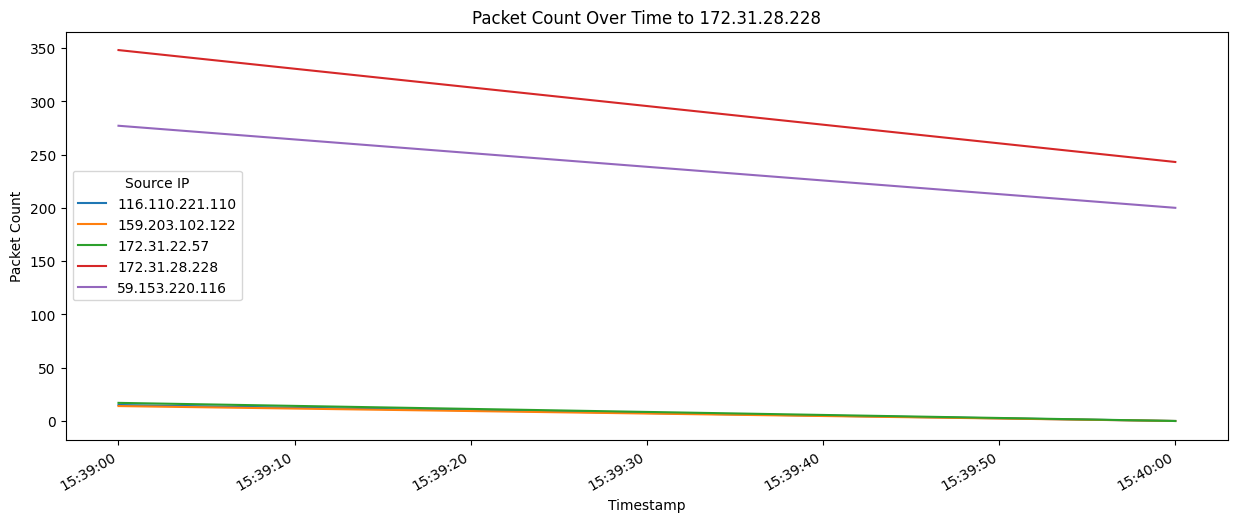

In [11]:
# pivot_table = time_series_data.unstack(level=0).fillna(0)

# Plotting
plt.figure(figsize=(15, 6))
resampled_df.plot(ax=plt.gca())
plt.title(f'Packet Count Over Time to {ip}')
plt.xlabel('Timestamp')
plt.ylabel('Packet Count')
plt.legend(title='Source IP')
plt.show()

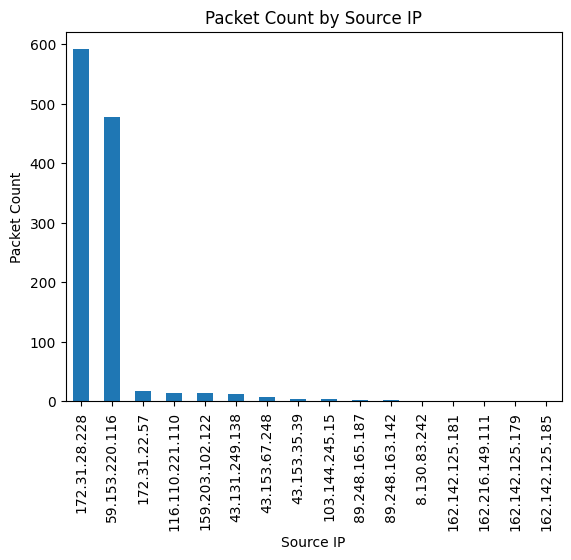

In [12]:
source_ip_counts = df['Source_IP'].value_counts()
source_ip_counts.plot(kind='bar')
plt.title('Packet Count by Source IP')
plt.xlabel('Source IP')
plt.ylabel('Packet Count')
plt.show()

In [21]:
protocol_counts = df.groupby('Protocol').resample('H').size().unstack(level=0).fillna(0)

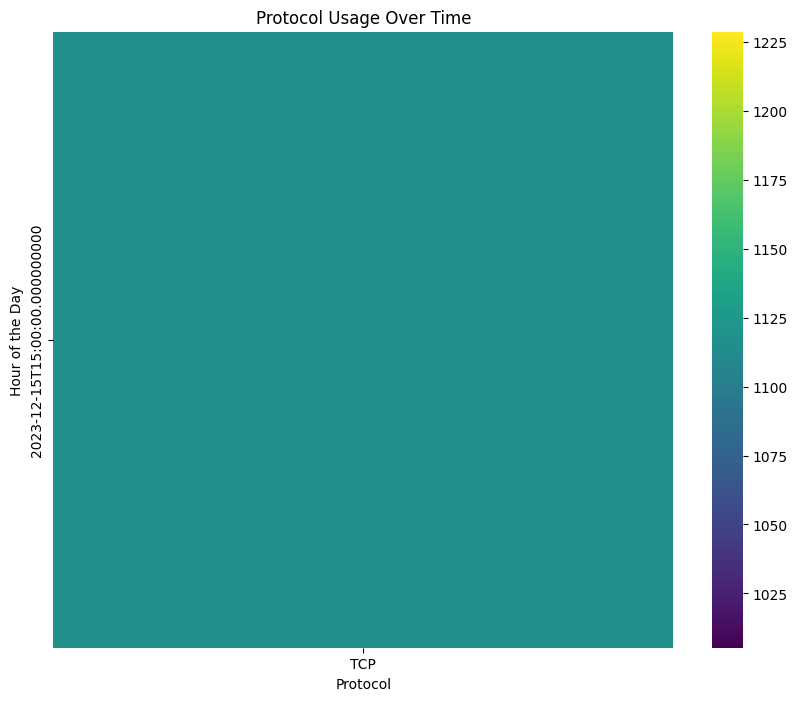

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(protocol_counts, cmap='viridis')
plt.title('Protocol Usage Over Time')
plt.xlabel('Protocol')
plt.ylabel('Hour of the Day')
plt.show()

In [1]:
import pandas as pd

In [23]:
train = {'Dst Port': 0,
 'Protocol': 0,
 'Timestamp': '14/02/2018 08:31:01',
 'Flow Duration': 112641719,
 'Tot Fwd Pkts': 3,
 'Tot Bwd Pkts': 0,
 'TotLen Fwd Pkts': 0,
 'TotLen Bwd Pkts': 0,
 'Fwd Pkt Len Max': 0,
 'Fwd Pkt Len Min': 0,
 'Fwd Pkt Len Mean': 0.0,
 'Fwd Pkt Len Std': 0.0,
 'Bwd Pkt Len Max': 0,
 'Bwd Pkt Len Min': 0,
 'Bwd Pkt Len Mean': 0.0,
 'Bwd Pkt Len Std': 0.0,
 'Flow Byts/s': 0.0,
 'Flow Pkts/s': 0.0266331163,
 'Flow IAT Mean': 56320859.5,
 'Flow IAT Std': 139.3000358938,
 'Flow IAT Max': 56320958,
 'Flow IAT Min': 56320761,
 'Fwd IAT Tot': 112641719,
 'Fwd IAT Mean': 56320859.5,
 'Fwd IAT Std': 139.3000358938,
 'Fwd IAT Max': 56320958,
 'Fwd IAT Min': 56320761,
 'Bwd IAT Tot': 0,
 'Bwd IAT Mean': 0.0,
 'Bwd IAT Std': 0.0,
 'Bwd IAT Max': 0,
 'Bwd IAT Min': 0,
 'Fwd PSH Flags': 0,
 'Bwd PSH Flags': 0,
 'Fwd URG Flags': 0,
 'Bwd URG Flags': 0,
 'Fwd Header Len': 0,
 'Bwd Header Len': 0,
 'Fwd Pkts/s': 0.0266331163,
 'Bwd Pkts/s': 0.0,
 'Pkt Len Min': 0,
 'Pkt Len Max': 0,
 'Pkt Len Mean': 0.0,
 'Pkt Len Std': 0.0,
 'Pkt Len Var': 0.0,
 'FIN Flag Cnt': 0,
 'SYN Flag Cnt': 0,
 'RST Flag Cnt': 0,
 'PSH Flag Cnt': 0,
 'ACK Flag Cnt': 0,
 'URG Flag Cnt': 0,
 'CWE Flag Count': 0,
 'ECE Flag Cnt': 0,
 'Down/Up Ratio': 0,
 'Pkt Size Avg': 0.0,
 'Fwd Seg Size Avg': 0.0,
 'Bwd Seg Size Avg': 0.0,
 'Fwd Byts/b Avg': 0,
 'Fwd Pkts/b Avg': 0,
 'Fwd Blk Rate Avg': 0,
 'Bwd Byts/b Avg': 0,
 'Bwd Pkts/b Avg': 0,
 'Bwd Blk Rate Avg': 0,
 'Subflow Fwd Pkts': 3,
 'Subflow Fwd Byts': 0,
 'Subflow Bwd Pkts': 0,
 'Subflow Bwd Byts': 0,
 'Init Fwd Win Byts': -1,
 'Init Bwd Win Byts': -1,
 'Fwd Act Data Pkts': 0,
 'Fwd Seg Size Min': 0,
 'Active Mean': 0,
 'Active Std': 0,
 'Active Max': 0,
 'Active Min': 0,
 'Idle Mean': 56320859.5,
 'Idle Std': 139.3000358938,
 'Idle Max': 56320958,
 'Idle Min': 56320761,
}

In [24]:
len(train.keys())

79

In [16]:
first_row_dict = df.iloc[1].to_dict()
first_row_dict

{'dst_port': 22.0,
 'protocol': 6.0,
 'flow_duration': 52987.995,
 'tot_fwd_pkts': 1.0,
 'tot_bwd_pkts': 1.0,
 'totlen_fwd_pkts': 54.0,
 'totlen_bwd_pkts': 122.0,
 'fwd_pkt_len_max': 54.0,
 'fwd_pkt_len_min': 54.0,
 'fwd_pkt_len_mean': 54.0,
 'fwd_pkt_len_std': 0.0,
 'bwd_pkt_len_max': 122.0,
 'bwd_pkt_len_min': 122.0,
 'bwd_pkt_len_mean': 122.0,
 'bwd_pkt_len_std': 0.0,
 'flow_byts_s': 3321.507069667384,
 'flow_pkts_s': 37.74439851894754,
 'flow_iat_mean': 851327383737287.9,
 'flow_iat_std': 851327383684299.9,
 'flow_iat_max': 1702654767421587.8,
 'flow_iat_min': 52987.995,
 'fwd_iat_tot': 0.0,
 'fwd_iat_mean': 0.0,
 'fwd_iat_std': 0.0,
 'fwd_iat_max': 0.0,
 'fwd_iat_min': 0.0,
 'bwd_iat_tot': 0.0,
 'bwd_iat_mean': 0.0,
 'bwd_iat_std': 0.0,
 'bwd_iat_max': 0.0,
 'bwd_iat_min': 0.0,
 'fwd_psh_flags': 0.0,
 'bwd_psh_flags': 0.0,
 'fwd_urg_flags': 0.0,
 'bwd_urg_flags': 0.0,
 'fwd_header_len': 20.0,
 'bwd_header_len': 20.0,
 'fwd_pkts_s': 18.87219925947377,
 'bwd_pkts_s': 18.872199259473

In [20]:
df = pd.read_csv("cicflow-refactor/test.csv")
df = df.drop(columns=['src_ip', 'dst_ip','src_port'])
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,6,2023-12-15 15:39:27,0.000,1,0,54,0,54.0,54.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,6,2023-12-15 15:39:27,52987.995,1,1,54,122,54.0,54.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,6,2023-12-15 15:39:27,108258.308,2,1,224,122,170.0,54.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,6,2023-12-15 15:39:27,108291.661,2,2,224,176,170.0,54.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,6,2023-12-15 15:39:27,110652.323,2,3,224,290,170.0,54.0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
first_row_dict = df.iloc[1].to_dict()
first_row_dict

{'dst_port': 22,
 'protocol': 6,
 'timestamp': '2023-12-15 15:39:27',
 'flow_duration': 52987.995,
 'tot_fwd_pkts': 1,
 'tot_bwd_pkts': 1,
 'totlen_fwd_pkts': 54,
 'totlen_bwd_pkts': 122,
 'fwd_pkt_len_max': 54.0,
 'fwd_pkt_len_min': 54.0,
 'fwd_pkt_len_mean': 54.0,
 'fwd_pkt_len_std': 0.0,
 'bwd_pkt_len_max': 122.0,
 'bwd_pkt_len_min': 122.0,
 'bwd_pkt_len_mean': 122.0,
 'bwd_pkt_len_std': 0.0,
 'flow_byts_s': 3321.507069667384,
 'flow_pkts_s': 37.74439851894754,
 'flow_iat_mean': 851327383737287.9,
 'flow_iat_std': 851327383684299.9,
 'flow_iat_max': 1702654767421587.8,
 'flow_iat_min': 52987.995,
 'fwd_iat_tot': 0.0,
 'fwd_iat_mean': 0.0,
 'fwd_iat_std': 0.0,
 'fwd_iat_max': 0.0,
 'fwd_iat_min': 0.0,
 'bwd_iat_tot': 0.0,
 'bwd_iat_mean': 0.0,
 'bwd_iat_std': 0.0,
 'bwd_iat_max': 0.0,
 'bwd_iat_min': 0.0,
 'fwd_psh_flags': 0,
 'bwd_psh_flags': 0,
 'fwd_urg_flags': 0,
 'bwd_urg_flags': 0,
 'fwd_header_len': 20,
 'bwd_header_len': 20,
 'fwd_pkts_s': 18.87219925947377,
 'bwd_pkts_s': 18

In [25]:
len(first_row_dict.keys()) == len(train.keys())

True

In [9]:
test = df.values

In [4]:
import joblib

In [5]:
clf2 = joblib.load("model.pkl")

In [30]:
result = clf2.predict(test)

In [33]:
test.shape

(1117, 78)

In [34]:
reshaped_array = test[0].reshape(1, -1)

In [37]:
result = clf2.predict(reshaped_array)

In [38]:
result[0]

-1

In [13]:
for i in result:
    if i == 1:
        print("OK")
    # elif i == -1:
    #     print("-1")

In [26]:
test[0]

array([2.200e+01, 6.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 5.400e+01,
       0.000e+00, 5.400e+01, 5.400e+01, 5.400e+01, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+01,
       0.000e+00, 0.000e+00, 0.000e+00, 5.400e+01, 5.400e+01, 5.400e+01,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.400e+01, 5.400e+01,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 5.400e+01, 0.000e+00, 0.000e+00, 4.103e+03,
       0.000e+00, 0.000e+00, 2.000e+01, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [ ]:
import joblib
model = joblib.load("model.pkl")

In [ ]:
#  1 :Benign 
# -1 :Malicious 
def predict(data):
    reshaped_array = data.reshape(1, -1)
    result = model.predict(reshaped_array)

    if result[0] == -1:
        print("Malicious")
    else:
         print("Benign ")
    